In [9]:
# Data Processing
# Ethan L. Edmunds, Jan 2025

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.optimize import curve_fit

In [10]:
# Load the data into a pandas Dataframe
file_path = 'Full_ICY_Durham_data'
df = pd.read_csv(file_path)

print(df.head())

   Tesla  Angle   Current   Voltage   Time
0    0.0    0.0 -0.018331  0.998907  0.046
1    0.0    0.0 -0.019037  0.998276  0.093
2    0.0    0.0 -0.018184  0.991219  0.138
3    0.0    0.0 -0.018356  0.985850  0.185
4    0.0    0.0 -0.018423  0.979989  0.230


In [19]:
# Define the distances in mm (converting to metres)
distance_1 = 13.08/1000
distance_2 = 12.7/1000

# Calculate Electric Field for both distances (E) for both distances
df['Electric Field (13.08mm)'] = df['Voltage']/distance_1
df['Electric Field (12.7mm)'] = df['Voltage']/distance_2

# Current correction



# Calculate current density
radius = 0.01  # in meters (for example)
A = np.pi * radius**2  # Area in square meters

# Calculate current density (J) for each row in the DataFrame
df['Current Density'] = df['Current'] / A  # Current Density in A/m²

print(df.head())

   Tesla  Angle   Current   Voltage   Time  Electric Field (13.08mm)  \
0    0.0    0.0 -0.018331  0.998907  0.046                 76.369037   
1    0.0    0.0 -0.019037  0.998276  0.093                 76.320795   
2    0.0    0.0 -0.018184  0.991219  0.138                 75.781269   
3    0.0    0.0 -0.018356  0.985850  0.185                 75.370795   
4    0.0    0.0 -0.018423  0.979989  0.230                 74.922706   

   Electric Field (12.7mm)  Current Density  
0                78.654094       -58.349385  
1                78.604409       -60.596653  
2                78.048740       -57.881470  
3                77.625984       -58.428963  
4                77.164488       -58.642230  


In [ ]:
# Finding n
def calculate_n():


C:\Users\Ethan\AppData\Local\Temp\ipykernel_21256\3097245165.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(tesla_values) * len(angle_values))  # Use 'tab20' colormap


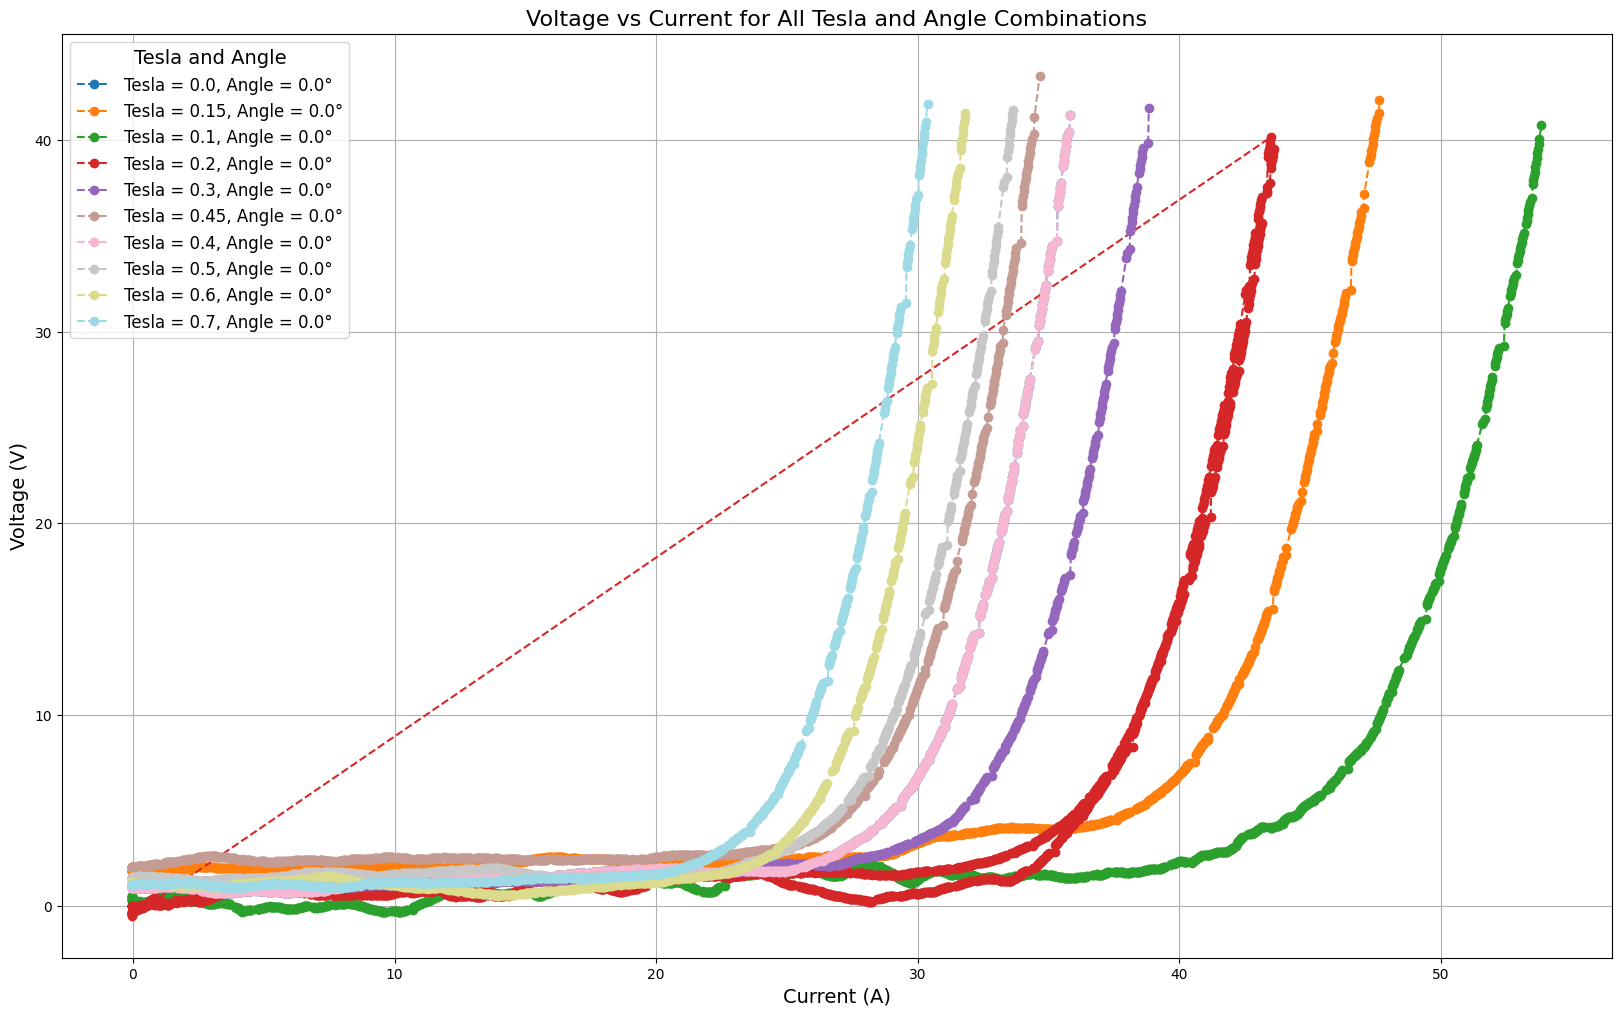

In [18]:
# Plotting some data by field_angle and tesla

unique_tesla = df['Tesla'].unique()
unique_angle = df['Angle'].unique()

def plot_voltage_current(df, tesla_values, angle_values):

    if isinstance(tesla_values, (float, int)):  # Check if it's a single value
        tesla_values = [tesla_values]  # Convert to a list
    if isinstance(angle_values, (float, int)):  # Check if it's a single value
        angle_values = [angle_values]  # Convert to a list

    plt.figure(figsize=(20, 12))  # Create a single plot for all data
    
    # Define a colormap for distinguishing the combinations
    cmap = cm.get_cmap('tab20', len(tesla_values) * len(angle_values))  # Use 'tab20' colormap

    # Loop over each Tesla and Angle combination to plot the data
    for idx, (tesla, angle) in enumerate([(tesla, angle) for tesla in tesla_values for angle in angle_values]):
        # Filter the DataFrame for the current Tesla and Angle values
        filtered_data = df[(df['Tesla'] == tesla) & (df['Angle'] == angle)]

        # If there is data to plot, plot it on the same graph
        if not filtered_data.empty:
            color = cmap(idx)  # Get a color from the colormap
            label = f'Tesla = {tesla}, Angle = {angle}°'  # Label for the legend
            plt.plot(filtered_data['Current'], filtered_data['Voltage'], label=label, color=color, marker='o', linestyle='--')

    # Add labels and legend
    plt.xlabel("Current (A)", fontsize=14)
    plt.ylabel("Voltage (V)", fontsize=14)
    plt.title("Voltage vs Current for All Tesla and Angle Combinations", fontsize=16)
    plt.legend(title="Tesla and Angle", fontsize=12, title_fontsize=14)
    plt.grid(True)
    plt.show()

plot_voltage_current(df, unique_tesla, unique_angle[0])
